# 【問題1】コンペティション内容の確認
コンペティションのOverviewページ読み、「Home Credit Default Risk」について以下の観点について確認してください。

・何を学習し、何を予測するのか→顧客のデータを学習し、顧客がローンを返済できるかできないかを判定する。

・どのようなファイルを作りKaggleに提出するか→顧客のIDと、返済できない確率の２列のデータが記録されたCSVファイルを提出する。

・提出されたものはどういった指標値で評価されるのか→roc_auc_score(ROC曲線の下の領域（面積）)で評価


# 【問題2】学習と検証
データを簡単に分析、前処理し、学習、検証するまでの一連の流れを作成・実行してください。


検証にはこのコンペティションで使用される評価指標を用いるようにしてください。学習に用いる手法は指定しません。



In [156]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import lightgbm as lgb
import warnings
warnings.simplefilter("ignore")
data1 = pd.read_csv("application_train.csv")
data2 = pd.read_csv("application_test.csv")
df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)

In [4]:
#相関係数が高い特徴量を探す
#X = df1[df1.columns[(df1.columns != 'TARGET') & (df1.columns != 'SK_ID_CURR')]]
#y = df1.TARGET
display(df1.corr().sort_values("TARGET",ascending=False).head(5))
display(df1.corr().sort_values("TARGET").head(5))

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
TARGET,-0.002108,1.000000,0.019187,-0.003982,-0.030369,-0.012817,-0.039645,-0.037227,0.078239,-0.044932,...,-0.007952,-0.001358,0.000215,0.003709,0.000930,0.002704,0.000788,-0.012462,-0.002022,0.019930
DAYS_BIRTH,-0.001500,0.078239,0.330938,0.027261,-0.055436,0.009445,-0.053442,-0.029582,1.000000,-0.615864,...,0.044498,0.003614,0.009015,0.027282,0.005285,0.002255,-0.001336,0.001372,-0.011799,-0.071983
REGION_RATING_CLIENT_W_CITY,-0.001138,0.060893,0.024781,-0.091735,-0.110915,-0.141682,-0.112208,-0.531535,0.008073,0.034624,...,-0.013672,-0.001530,0.002609,-0.001501,0.006239,-0.001953,0.001102,-0.067741,0.004773,0.010683
REGION_RATING_CLIENT,-0.001075,0.058899,0.025423,-0.085465,-0.101776,-0.128525,-0.103786,-0.532877,0.009361,0.032750,...,-0.012532,-0.001205,0.002217,-0.001887,0.006312,-0.002241,0.001683,-0.069712,0.005436,0.011494
DAYS_LAST_PHONE_CHANGE,-0.000858,0.055218,-0.005865,-0.018585,-0.073701,-0.063747,-0.076313,-0.044013,0.082939,0.023032,...,0.047604,0.006852,0.009171,0.009826,-0.000858,0.002337,-0.003495,-0.041244,-0.001451,-0.112725


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
EXT_SOURCE_3,0.000222,-0.178919,-0.042710,-0.030229,0.043516,0.030752,0.047717,-0.006001,-0.205478,0.113434,...,-0.016152,-0.002590,-0.013837,-0.013058,-0.001193,-0.007190,-0.021258,-0.007856,-0.025131,-0.071449
EXT_SOURCE_2,0.002342,-0.160472,-0.018015,0.060925,0.131228,0.125804,0.139367,0.198924,-0.091996,-0.020767,...,0.001874,0.003256,0.000614,-0.007236,-0.004077,0.000553,0.001507,0.051981,-0.002849,-0.021984
EXT_SOURCE_1,0.000082,-0.155317,-0.138470,0.026232,0.168429,0.119398,0.175502,0.099997,-0.600610,0.289848,...,-0.025739,0.005131,-0.005102,-0.019208,-0.003963,-0.005087,-0.001801,0.030820,-0.003631,0.006562
DAYS_EMPLOYED,0.001366,-0.044932,-0.239818,-0.064223,-0.066838,-0.104332,-0.064842,-0.003980,-0.615864,1.000000,...,-0.040396,-0.010040,-0.010135,-0.008396,-0.004735,0.000472,0.003072,-0.034457,0.015345,0.049988
FLOORSMAX_AVG,0.004851,-0.044003,-0.009705,0.060171,0.103296,0.130174,0.108512,0.322652,0.001634,-0.015970,...,0.012230,0.000900,-0.002702,-0.005814,0.003101,0.002946,-0.000050,0.046762,-0.000841,-0.019750


相関係数が０.１を超えているのはEXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3の３つだけであるため今回はこの３つの特徴量を使用する

In [5]:
feature_list = ["EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3"]
df_train_x = df1[feature_list]
df_train_y = df1.TARGET
df_test = df2[feature_list]

In [45]:
print("df_train_xの平均値:\n{}".format(df_train_x.mean()))
print("df_testの平均値:\n{}".format(df_test.mean()))

df_train_xの平均値:
EXT_SOURCE_1    0.502130
EXT_SOURCE_2    0.514393
EXT_SOURCE_3    0.510853
dtype: float64
df_testの平均値:
EXT_SOURCE_1    0.501180
EXT_SOURCE_2    0.518021
EXT_SOURCE_3    0.500106
dtype: float64


In [10]:
#訓練用データもテスト用データも変数３つとも平均値はおよそ0.5であるため今回は0.5で欠損値を埋める
df_train_x_fill = df_train_x.fillna(0.5)
df_test_fill = df_test.fillna(0.5)

In [13]:
x_train,x_val,y_train,y_val = train_test_split(df_train_x_fill,df_train_y,train_size=0.75,random_state=0)

In [14]:
#x_trainを用いてx_train,x_val,df_test_xを標準化
scaler = StandardScaler()
scaler.fit(x_train)
x_train_std = scaler.transform(x_train)  #訓練用データ
x_val_std = scaler.transform(x_val)  #検証用データ
x_test_std = scaler.transform(df_test_fill)  #提出時の評価用データ

In [16]:
#ロジスティック回帰
lr = LogisticRegression()
lr.fit(x_train_std,y_train)
#２値分類の予測(0か１が入る)
y_pred = lr.predict(x_val_std)
#0になる確率,1になる確率を返す２列の行列（小数が入る）
y_pred_proba = lr.predict_proba(x_val_std)

In [18]:
#ROC_AUCスコア
roc_auc_score(y_val,y_pred_proba[:,1])  #1になる確率

0.7185187102649248

In [20]:
#正解率
accuracy_score(y_pred,y_val)

0.9205364343505295

># 【問題3】テストデータに対する推定
テストデータ（application_test.csv）に対して推定を行い、Kaggleに提出を行ってください。  
正しく提出が行えていれば、精度は低くても構いません。

In [22]:
sub_preds = lr.predict(x_test_std)
submission = pd.DataFrame({"SK_ID_CURR":df2.SK_ID_CURR,"TARGET":sub_preds})
submission.to_csv("submission_baseline_model.csv",index = False)

精度は0.50266であった

># 【問題4】特徴量エンジニアリング
精度を上げるために以下のような観点で 特徴量エンジニアリング（Feature Engineering） を行ってください。  
・どの特徴量を使うか  
・どう前処理をするか  
何をした時に検証データに対する評価指標がどのようになったかをまとめてください。最低5パターンの学習・検証を行ってください。  
精度が高かったものに関してはテストデータに対しても推定を行い、Kaggleに提出を行ってください。

まずはカテゴリ変数をダミー変数に変換し、目的変数との相関係数の順位が変わるか確認する。

In [249]:
df1_dummies = pd.get_dummies(df1).fillna(0)
df2_dummies = pd.get_dummies(df2).fillna(0)

In [253]:
#特徴量の数をテストデータに合わせておく
name_list = np.append(["TARGET"],df2_dummies.keys())
df1_dummies = df1_dummies[name_list]

In [254]:
display(df1_dummies.corr().sort_values("TARGET",ascending=False).head(5))
display(df1_dummies.corr().sort_values("TARGET",ascending=True).head(5))

,TARGET,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
TARGET,1.000000,-0.002108,0.019187,-0.003982,-0.030369,-0.012794,-0.039565,-0.037227,0.078239,-0.044932,...,0.000982,-0.006777,-0.001713,-0.009384,0.000628,-0.033119,-0.012657,0.007946,-0.042201,0.004829
DAYS_BIRTH,0.078239,-0.001500,0.330938,0.027261,-0.055436,0.009419,-0.053943,-0.029582,1.000000,-0.615864,...,0.000388,-0.006749,-0.000262,0.004421,-0.000690,-0.013597,-0.010964,0.008758,-0.019852,0.005434
REGION_RATING_CLIENT_W_CITY,0.060893,-0.001138,0.024781,-0.091735,-0.110915,-0.141615,-0.112168,-0.531535,0.008073,0.034624,...,-0.002086,-0.049740,-0.015432,-0.055445,-0.018756,-0.110948,-0.056365,0.018482,-0.169696,0.012061
REGION_RATING_CLIENT,0.058899,-0.001075,0.025423,-0.085465,-0.101776,-0.128457,-0.103720,-0.532877,0.009361,0.032750,...,-0.002813,-0.054240,-0.012279,-0.053854,-0.020729,-0.073936,-0.056535,0.025218,-0.141678,0.017752
NAME_INCOME_TYPE_Working,0.057481,-0.002610,0.136604,-0.024522,-0.056512,-0.043900,-0.057716,-0.115337,0.304568,-0.483907,...,0.000231,-0.022912,-0.004873,-0.023556,-0.011490,-0.029961,-0.010263,0.007134,-0.050594,0.011262


,TARGET,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
EXT_SOURCE_2,-0.159030,0.002521,-0.017903,0.061014,0.131993,0.126501,0.139976,0.196835,-0.090487,-0.021427,...,0.000916,0.015291,0.009413,0.029394,0.006477,0.075499,0.062823,-0.019844,0.126651,-0.008556
EXT_SOURCE_3,-0.119572,0.000324,-0.009778,0.001328,0.059305,0.023858,0.061598,-0.014425,-0.151220,0.063750,...,0.000934,0.002265,-0.001803,-0.000376,0.002994,0.012117,0.013802,-0.004421,0.022583,-0.003894
EXT_SOURCE_1,-0.064698,-0.000356,0.051216,0.038353,0.086336,0.090290,0.091939,0.046284,0.059073,-0.095800,...,-0.005353,0.012466,0.007257,0.016927,0.001134,0.044397,0.027644,-0.011707,0.067208,-0.005706
NAME_EDUCATION_TYPE_Higher education,-0.056593,-0.000495,0.033654,0.095342,0.128147,0.144578,0.140967,0.066604,0.115808,-0.104191,...,-0.001579,0.013323,0.011535,0.041954,0.005999,0.069466,0.048432,-0.022830,0.111107,-0.015888
CODE_GENDER_F,-0.054704,0.000749,-0.047394,-0.074731,-0.021587,-0.076974,-0.022534,-0.014066,-0.148074,0.156015,...,0.001104,0.006396,0.003938,-0.005623,0.002666,0.007380,0.020702,0.006651,0.029347,0.005172


順位が変動したので、次にlightgbmを用いて変数の重要度を求める。

まずはLightGBMを用いてモデルに学習させる

In [255]:
K = 5
value = np.zeros(6)
df1_x = df1.select_dtypes("number").drop("TARGET",axis=1).drop("SK_ID_CURR",axis=1)
df1_y = df1_dummies.TARGET
kf_credit = KFold(n_splits=K,random_state=0)
for train_index,test_index in kf_credit.split(df1_x):
    x_train,x_val = df1_x.iloc[train_index],df1_x.iloc[test_index]
    y_train,y_val = df1_y.iloc[train_index],df1_y.iloc[test_index]
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_val = scaler.transform(x_val)
    model1 = lgb.LGBMClassifier(random_state=0)
    model1.fit(x_train,y_train)
    y_pred = model1.predict_proba(x_val)
    value[0] += roc_auc_score(y_val,y_pred[:,1])
print("roc_auc_score(平均):{}".format(value[0]/K))

roc_auc_score(平均):0.7502816752352678


上では数値データだけを扱ったが、次はカテゴリ変数をダミー変数に変換してデータ全体を分析する

In [256]:
df1_x = df1_dummies.drop("TARGET",axis=1).drop("SK_ID_CURR",axis=1)
df1_y = df1_dummies.TARGET
value[1] = 0
kf_credit = KFold(n_splits=K,random_state=0)
for train_index,test_index in kf_credit.split(df1_x):
    x_train,x_val = df1_x.iloc[train_index],df1_x.iloc[test_index]
    y_train,y_val = df1_y.iloc[train_index],df1_y.iloc[test_index]
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_val = scaler.transform(x_val)
    model2 = lgb.LGBMClassifier(random_state=0)
    model2.fit(x_train,y_train)
    y_pred = model2.predict_proba(x_val)
    value[1] += roc_auc_score(y_val,y_pred[:,1])
print("roc_auc_score(平均):{}".format(value[1]/K))

roc_auc_score(平均):0.7556623597324376


ここで、ダミー変数を含めた特徴量の重要度を可視化する

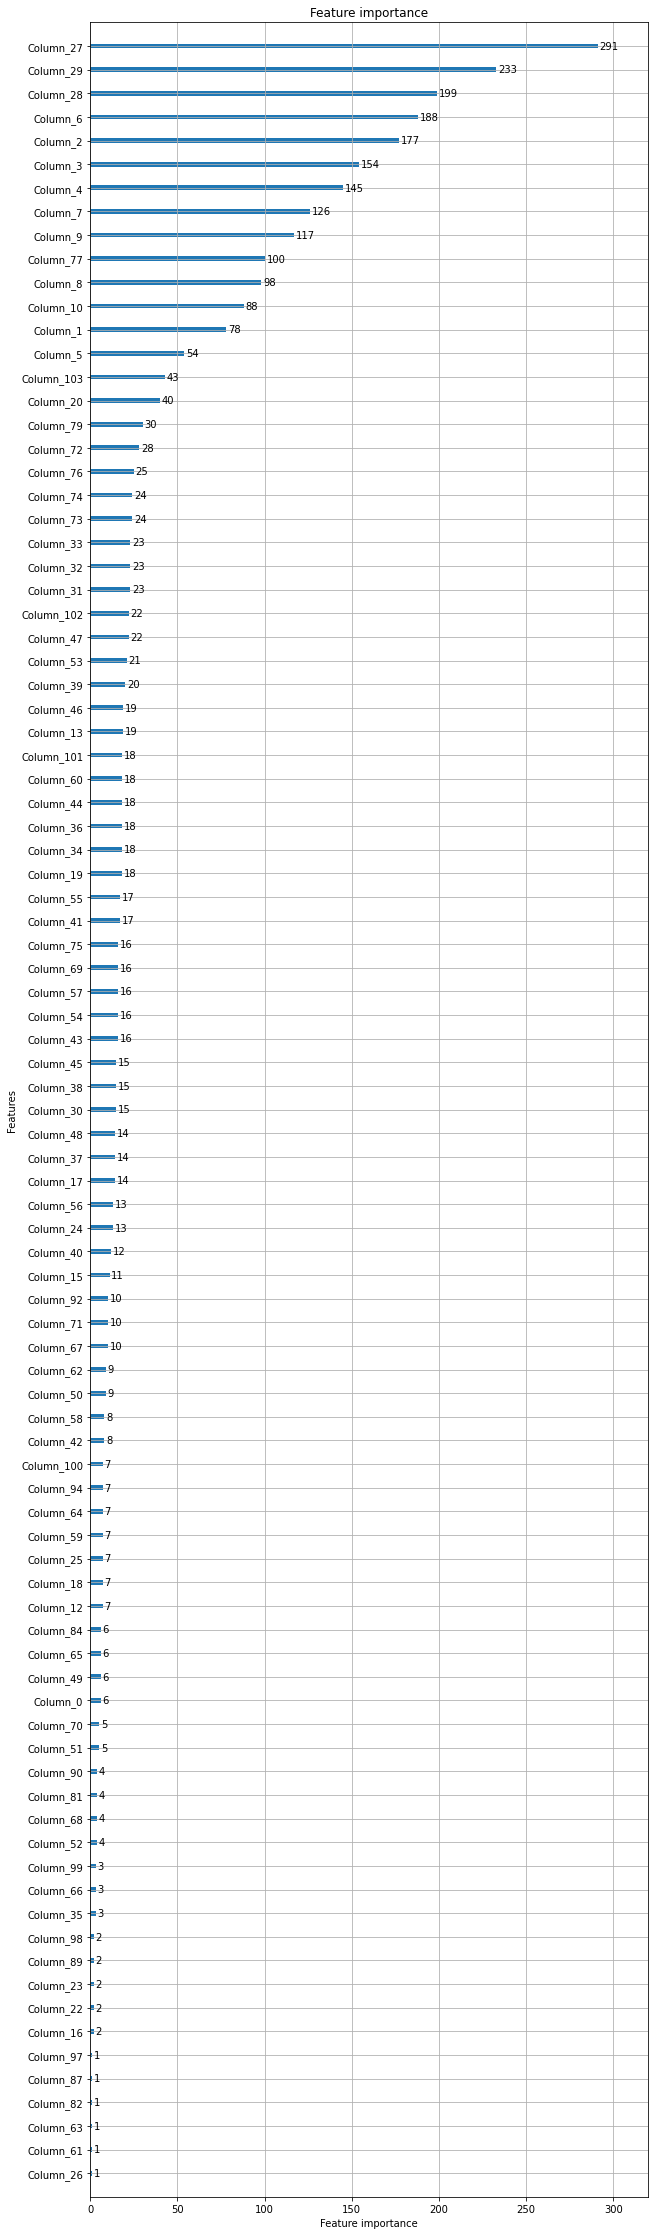

In [257]:
#ダミー変数を含めた特徴量の重要度を可視化する
lgb.plot_importance(model1,figsize=(10,40))
plt.show()

In [258]:
#各特徴量の重要度をfeature_importanceに残しておく
feature_importance = np.array(model2.feature_importances_)
print(feature_importance)

[  5  68 161 161 143  64 201 127  82 126  46   0   0  18   1   9   2   8
   5  19  32   0   3   4  14   1   2 190 196 225  14  12   7  13  16   3
  12  14   6  15  11  15   3  10  15   7  11   8   7   0   5   2   2  11
  11   7   7   8   5   6   5   3   3   1   1   2   1   5   3   7   4   7
  21  17  21  18  22 104   0  19   0   3   2   0   0   0   0   1   0   1
   2   0   9   0   6   0   0   0   0   3   6   9  19  45  29   0  37  18
  32   0   5   0   1   0   0   0   1   2   4   0   4   1   4   0   0  15
   0  24   1   6  20   2  27   3   4   3   2   4   2   2   1   1   3   2
   1  10   9   0   4   0   6   3   4   1   3   0   3   0   1   1   4   5
   1   1   2   2   6   0   0   4   1   0   7   1   9   0   0   0   0   2
   0   1   0   0   0   0   0   0   3   0   0   0   0   0   0   2   0   1
   6   0   0   2   0   7   0   1   9   3   0  15   1   1   0   6   2   0
   0   0   0   0   1  12   5   1   0   1   0   1   2   1   2   0   2   2
   0   1   5   6   0   0   1]


特徴量ごとの重要度がわかったので、上位30件の特徴量に絞ってLightGBMを用いてモデルに学習させる

In [259]:
index_list = [27,29,28,6,2,3,4,7,9,77,8,10,1,5,103,20,79,72,76,74,73,33,32,31,102,47,53,39,46,13]
columns_list = df1_x.keys()[index_list]

In [260]:
value[2] = 0
df1_x = df1_dummies[columns_list]
df1_y = df1_dummies.TARGET
kf_credit = KFold(n_splits=K,random_state=0)
for train_index,test_index in kf_credit.split(df1_x):
    x_train,x_val = df1_x.iloc[train_index],df1_x.iloc[test_index]
    y_train,y_val = df1_y.iloc[train_index],df1_y.iloc[test_index]
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_val = scaler.transform(x_val)
    model3 = lgb.LGBMClassifier(random_state=0)
    model3.fit(x_train,y_train)
    y_pred = model3.predict_proba(x_val)
    value[2] += roc_auc_score(y_val,y_pred[:,1])
print("roc_auc_score(平均):{}".format(value[2]/K))

roc_auc_score(平均):0.7491206447406351


ここで一度、上で用いたロジスティック回帰を使うことでLightGBMがどれだけ高い精度を出せているのか確認する。  
特徴量は一つ上のセルのmodel3に使ったものと同じものを使う。

In [261]:
for train_index,test_index in kf_credit.split(df1_x):
    x_train,x_val = df1_x.iloc[train_index],df1_x.iloc[test_index]
    y_train,y_val = df1_y.iloc[train_index],df1_y.iloc[test_index]
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_val = scaler.transform(x_val)
    model4 = LogisticRegression(random_state=0)
    model4.fit(x_train,y_train)
    y_pred = model4.predict_proba(x_val)
    value[3] += roc_auc_score(y_val,y_pred[:,1])
print("roc_auc_score(平均):{}".format(value[3]/K))

roc_auc_score(平均):0.7168808918255256


最後に、特徴量ごとの重要度を正規化して、それを標準化した各特徴量にかけたものをLightGBMで分析するとどうなるか検証する。  
全ての特徴量を使った場合と、３０個に絞った場合で検証する。

In [262]:
mm = MinMaxScaler()
feature_importance = np.array(model2.feature_importances_)
feature_importance = feature_importance[:,np.newaxis]
feature_norm = mm.fit_transform(feature_importance)

In [263]:
value[4] = 0
df1_x = df1_dummies.drop("TARGET",axis=1).drop("SK_ID_CURR",axis=1)
df1_y = df1_dummies.TARGET
for train_index,test_index in kf_credit.split(df1_x):
    x_train,x_val = df1_x.iloc[train_index],df1_x.iloc[test_index]
    y_train,y_val = df1_y.iloc[train_index],df1_y.iloc[test_index]
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(np.array(x_train)*feature_norm.T)
    x_val = scaler.transform(np.array(x_val)*feature_norm.T)
    model5 = lgb.LGBMClassifier(random_state=0)
    model5.fit(x_train,y_train)
    y_pred = model5.predict_proba(x_val)
    value[4] += roc_auc_score(y_val,y_pred[:,1])
print("roc_auc_score(平均):{}".format(value[4]/K))

roc_auc_score(平均):0.7561199122862433


In [264]:
feature_30 = feature_importance[index_list,0]
feature_30_norm = mm.fit_transform(feature_30[:,np.newaxis])

In [265]:
#特徴量３０個
value[5] = 0
df1_x = df1_x[columns_list]
df1_y = df1_dummies.TARGET
for train_index,test_index in kf_credit.split(df1_x):
    x_train,x_val = df1_x.iloc[train_index],df1_x.iloc[test_index]
    y_train,y_val = df1_y.iloc[train_index],df1_y.iloc[test_index]
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(np.array(x_train)*feature_30_norm.T)
    x_val = scaler.transform(np.array(x_val)*feature_30_norm.T)
    model6 = lgb.LGBMClassifier(random_state=0)
    model6.fit(x_train,y_train)
    y_pred = model6.predict_proba(x_val)
    value[5] += roc_auc_score(y_val,y_pred[:,1])
print("roc_auc_score(平均):{}".format(value[5]/K))

roc_auc_score(平均):0.7492323434466636


In [266]:
pd.DataFrame(value.reshape(1,6)/K,columns = ["lgb","lgb(ダミー変数使用)","lgb(特徴量30個)",\
                              "ロジスティック回帰","lgb(特徴量*重要度)","lgb(特徴量30個*重要度)"])

,lgb,lgb(ダミー変数使用),lgb(特徴量30個),ロジスティック回帰,lgb(特徴量*重要度),lgb(特徴量30個*重要度)
0,0.750282,0.755662,0.749121,0.716881,0.75612,0.749232


上の表を見ると、特徴量に正規化した重要度をかけたmodel5が最も精度が高いため、このモデルを用いてテストデータを分析したものを提出する。

In [273]:
df2_dummies = pd.get_dummies(df2).fillna(0)
df2_dummies = df2_dummies.drop("SK_ID_CURR",axis=1)
scaler = StandardScaler()
scaler.fit(df2_dummies)
x_test = scaler.transform(np.array(df2_dummies)*feature_norm.T)
y_pred = model5.predict_proba(x_test)
submission = pd.DataFrame({"SK_ID_CURR":df2.SK_ID_CURR,"TARGET":y_pred[:,1]})
submission.to_csv("submission_feature_engineering.csv",index = False)

Kaggleに提出したところ、スコアは0.71528と表示された。